In [21]:
import csv
from sklearn.feature_extraction.text import TfidfVectorizer

with open("amazon_review_300.csv", "rb") as f:
     
    csvfile = csv.reader(f, delimiter=',')

    label,title,text=zip(*csvfile)

# convert tuple to list
label=list(label)
text=list(text)

tfidf_vect = TfidfVectorizer(stop_words="english") 
dtm= tfidf_vect.fit_transform(text)

from sklearn.naive_bayes import MultinomialNB
# import method for split train/test data set
from sklearn.model_selection import train_test_split
# import method to calculate metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB


# split dataset into train (70%) and test sets (30%)
X_train, X_test, y_train, y_test = train_test_split(\
                dtm, label, test_size=0.3, random_state=0)

# train a multinomial naive Bayes model using the testing data
clf = MultinomialNB().fit(X_train, y_train)

# predict the news group for the test dataset
predicted=clf.predict(X_test)

# get the list of unique labels
labels=list(set(label))

metrics = ['precision_macro', 'recall_macro', "f1_macro"]

clf = MultinomialNB()
#clf = MultinomialNB(alpha=0.5)

cv = cross_validate(clf, dtm, label, scoring=metrics, cv=5)


print("Test data set average precision:")
print(cv['test_precision_macro'])
print("\nTest data set average recall:")
print(cv['test_recall_macro'])
print("\nTest data set average fscore:")
print(cv['test_f1_macro'])

Test data set average precision:
[ 0.63034759  0.69768935  0.64402619  0.72222222  0.82921512]

Test data set average recall:
[ 0.60551948  0.671875    0.59821429  0.6875      0.76215278]

Test data set average fscore:
[ 0.5950938   0.66773535  0.57394257  0.6827262   0.76217054]


In [19]:
import nltk, re, string
from sklearn.preprocessing import normalize
from nltk.corpus import stopwords
# numpy is the package for matrix cacluation
import numpy as np  
import string
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import csv
from sklearn.naive_bayes import MultinomialNB
# import method for split train/test data set
from sklearn.model_selection import train_test_split
# import method to calculate metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB

wordnet_lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(pos_tag):
    
    # if pos tag starts with 'J'
    if pos_tag.startswith('J'):
        # return wordnet tag "ADJ"
        return wordnet.ADJ
    
    # if pos tag starts with 'V'
    elif pos_tag.startswith('V'):
        # return wordnet tag "VERB"
        return wordnet.VERB
    
    # if pos tag starts with 'N'
    elif pos_tag.startswith('N'):
        # return wordnet tag "NOUN"
        return wordnet.NOUN
    
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        # be default, return wordnet tag "NOUN"
        return wordnet.NOUN

def get_doc_tokens(doc, lemma = False):
    stop_words = stopwords.words('english')
    tokens=[token.strip() \
            for token in nltk.word_tokenize(doc.lower()) \
            if token.strip() not in stop_words and\
               token.strip() not in string.punctuation]

    if lemma:
        tagged_tokens= nltk.pos_tag(tokens)
        #print(tagged_tokens)

        tokens=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) \
          # tagged_tokens is a list of tuples (word, tag)
          for (word, tag) in tagged_tokens \
          # remove stop words
          if word not in stop_words and \
          # remove punctuations
          word not in string.punctuation]
        
    return tokens

def tfidf(docs):
    # step 2. process all documents to get list of token list
    docs_tokens=[get_doc_tokens(doc,True) for doc in docs]
    voc=list(set([token for tokens in docs_tokens \
              for token in tokens]))

    dtm=np.zeros((len(docs), len(voc)))

    for row_index,tokens in enumerate(docs_tokens):
        for token in tokens:
            col_index=voc.index(token)
            dtm[row_index, col_index]+=1
                   
    doc_len=dtm.sum(axis=1, keepdims=True)
    tf=np.divide(dtm, doc_len)
    
    doc_freq=np.copy(dtm)
    doc_freq[np.where(doc_freq>0)]=1

    smoothed_idf=np.log(np.divide(len(docs)+1, np.sum(doc_freq, axis=0)+1))+1

    smoothed_tf_idf=normalize(tf*smoothed_idf)
    
    return dtm

review=[]

with open("amazon_review_300.csv", "rb") as f:
     
    csvfile = csv.reader(f, delimiter=',')

    label,title,text=zip(*csvfile)

# convert tuple to list
label=list(label)
review=list(text)
#print(review)
#get_doc_tokens(review)

dtm1=tfidf(review)




# split dataset into train (70%) and test sets (30%)
X_train, X_test, y_train, y_test = train_test_split(\
                dtm1, label, test_size=0.3, random_state=0)

# train a multinomial naive Bayes model using the testing data
clf = MultinomialNB().fit(X_train, y_train)

# predict the news group for the test dataset
predicted=clf.predict(X_test)

# get the list of unique labels
labels=list(set(label))

metrics = ['precision_macro', 'recall_macro', "f1_macro"]

clf = MultinomialNB()
#clf = MultinomialNB(alpha=0.8)

cv = cross_validate(clf, dtm1, label, scoring=metrics, cv=5)
print("Test data set average precision:")
print(cv['test_precision_macro'])
print("\nTest data set average recall:")
print(cv['test_recall_macro'])
print("\nTest data set average fscore:")
print(cv['test_f1_macro'])

Test data set average precision:
[ 0.64170259  0.71579533  0.64905451  0.75139043  0.71025346]

Test data set average recall:
[ 0.64231602  0.71651786  0.64955357  0.75223214  0.71122685]

Test data set average fscore:
[ 0.63924731  0.71595656  0.64912281  0.74993054  0.71053391]


In [14]:
# import pipeline class
from sklearn.pipeline import Pipeline

# import GridSearch
from sklearn.model_selection import GridSearchCV


text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())
                   ])

parameters = {'tfidf__min_df':[1,2,3],
              'tfidf__stop_words':[None,"english"],
              'clf__alpha': [0.5,1.0,1.5,2.0],
}

# the metric used to select the best parameters
metric =  "f1_macro"

# GridSearch also uses cross validation
gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)
gs_clf = gs_clf.fit(text, label)

for param_name in gs_clf.best_params_:
    print(param_name,": ",gs_clf.best_params_[param_name])

print("best f1 score:", gs_clf.best_score_)


('tfidf__stop_words', ': ', None)
('tfidf__min_df', ': ', 3)
('clf__alpha', ': ', 0.5)
('best f1 score:', 0.74038261618491519)


[[300, 0.69653409090909091, 0.68763938267614744, 0.68538551565022154], [600, 0.6914639262610941, 0.68543752317389695, 0.68351216795109593], [900, 0.68565688868860986, 0.67083333333333317, 0.66799150681011377], [1200, 0.69576885563182889, 0.69264828738512951, 0.69038942988250718], [1500, 0.73678221818665113, 0.73176035659813599, 0.73009361905151537], [1800, 0.75196279289094459, 0.7473558274014579, 0.74648773574096161], [2100, 0.76072266991348292, 0.75779650527564002, 0.75706363751716788], [2400, 0.76674082676773292, 0.76422026406151766, 0.76396711732440825], [2700, 0.76892396039001509, 0.76743767365736693, 0.76707124322919817], [3000, 0.76118110756961133, 0.75975874710734348, 0.75954848903353245], [3300, 0.74936459965808633, 0.74668510034323088, 0.74662832607319174], [3600, 0.77293093579294769, 0.76893609847292832, 0.76907487273481645], [3900, 0.78121324722504459, 0.78034052665693254, 0.78013829218098751], [4200, 0.79850944923021527, 0.79802548517642935, 0.79793775904885889], [4500, 0.7

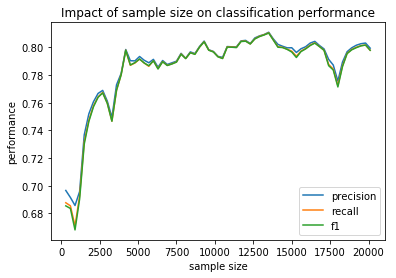

In [22]:
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

with open("amazon_review_large.csv", "rb") as f:
     
    csvfile = csv.reader(f, delimiter=',')

    label,text=zip(*csvfile)
    label=list(label)
    text=list(text)
    
sample_size = 0  
metric=[]
while sample_size <= 20000:
    sample_size += 300
# convert tuple to list
    
    tfidf_vect = TfidfVectorizer(stop_words="english") 
    dtm= tfidf_vect.fit_transform(text[0:sample_size])

    metrics = ['precision_macro', 'recall_macro', "f1_macro"]
    

# initiate an linear SVM model
    clf = svm.LinearSVC()

    cv = cross_validate(clf, dtm, label[0:sample_size], scoring=metrics, cv=10)
    
    metric.append([sample_size,np.mean(cv['test_precision_macro']),np.mean(cv['test_recall_macro']),np.mean(cv['test_f1_macro'])])
    
    
print(metric)
results=np.array(metric)
plt.plot(results[:,0],results[:,1],'-',label='precision')
plt.plot(results[:,0],results[:,2],'-',label='recall')
plt.plot(results[:,0],results[:,3],'-',label='f1')
plt.title('Impact of sample size on classification performance')
plt.ylabel('performance')
plt.xlabel('sample size')
plt.legend()
plt.show()
